<a href="https://colab.research.google.com/github/cabamarcos/Captcha_recognition/blob/main/IAO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

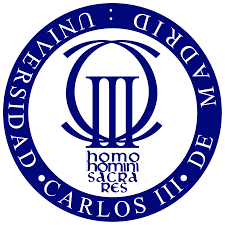

# PRÁCTICA FINAL: INTELIGENCIA ARTIFICIAL EN LAS ORGANIZACIONES

Pablo Hidalgo: 100451225.
Pablo Brasero: 100451247.
Miguel Castuera: 100451285.
Marcos Caballero: 100451047.   



# Introducción

In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from collections import Counter
from pathlib import Path


from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


Según el creador de la publicación en kaggle, el dataset contiene palabras de 5 letras cada una.
Las palabras tienen ruido (blur y lineas).
Las imagenes PNG contienen 200x50 pixeles

Primero vamos a ver la naturaleza de los datos.
Para ello vamos a mostrarlos por pantalla.

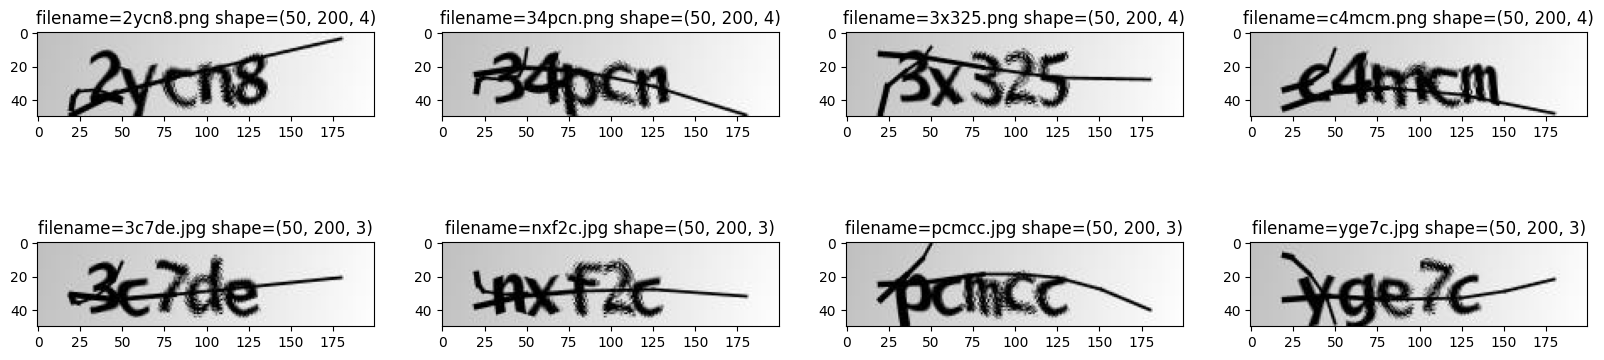

In [14]:
img_2ycn8 = mpimg.imread('2ycn8.png')
img_34pcn = mpimg.imread('34pcn.png')
img_3x325 = mpimg.imread('3x325.png')
img_c4mcm = mpimg.imread('c4mcm.png')
img_3c7de = mpimg.imread('3c7de.jpg')
img_nxf2c = mpimg.imread('nxf2c.jpg')
img_pcmcc = mpimg.imread('pcmcc.jpg')
img_yge7c = mpimg.imread('yge7c.jpg')
samples = {'2ycn8.png':img_2ycn8, '34pcn.png':img_34pcn, '3x325.png':img_3x325, 'c4mcm.png':img_c4mcm,
           '3c7de.jpg':img_3c7de, 'nxf2c.jpg':img_nxf2c, 'pcmcc.jpg':img_pcmcc, 'yge7c.jpg':img_yge7c}

fig=plt.figure(figsize=(20, 5))
pos = 1
for filename, img in samples.items():
    fig.add_subplot(2, 4, pos)
    pos = pos+1
    plt.imshow(img)
    plt.title('filename='+filename+' shape='+str(img.shape))
plt.show()

Como podemos ver, los nombres de las imágenes obviamente coincide con los caracteres de las imágenes.

Cabe destacar que al ver las imágenes, hemos notado que los numeros y letras se repiten notablemente, por lo que vamos a hacer un análisis para ver que caracteres se están utilizando, ya que nos puede ayudar en el futuro entrenamiento.

In [32]:
# Especifica la ruta a la carpeta que contiene las imágenes
image_folder = Path('/content/')

# Obtiene la lista de imágenes en la carpeta
images = list(image_folder.glob("*.png"))

# Store all the characters in a set
characters = set()

# Store all the labels in a set
labels = set()

# Create a list of dictionaries to store the image-label pair info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.name.split(".png")[0]
    # 2. Store the length of this captcha
    captcha_length = len(label)
    # 3. Store the image-label pair info
    dataset.append({"img_path": str(img_path), "label": label})
    # 4. Store the characters present
    characters.update(set(label))
    # 5. Store the labels
    labels.add(label)

# Convert the list of dictionaries into a DataFrame
dataset = pd.DataFrame(dataset)

print("Number of images found:", len(images))
print("Number of labels found:", len(labels))
print("Number of unique characters:", len(characters))
print("Characters present:", characters)


Number of images found: 1040
Number of labels found: 1040
Number of unique characters: 19
Characters present: {'4', '5', 'n', 'p', 'x', '3', 'f', 'm', 'c', 'y', 'b', '2', 'e', '6', 'g', '8', 'w', 'd', '7'}


Como podemos ver, solo contiene 19 caracteres distintos, en vez de los 36 posibles si combinamos números y letras si excluimos la ñ, por lo que nuestro espacio de trabajo y búsqueda se ha reducido considerablemente.

Ahora vamos a ver con cuanta frecuencia se repite cada caracter

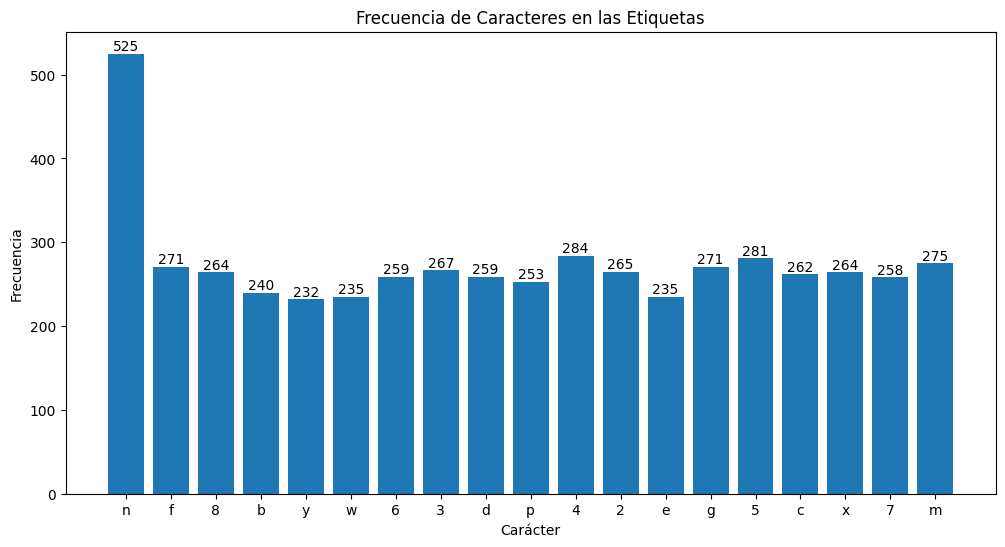

In [29]:
# Calcula la frecuencia de cada carácter
character_counts = Counter("".join(dataset["label"]))

# Convierte los resultados en dos listas separadas para plotear
characters = list(character_counts.keys())
counts = list(character_counts.values())

# Crea la gráfica de barras
plt.figure(figsize=(12, 6))
plt.bar(characters, counts)

# Agrega etiquetas con el número exacto en cada barra
for i in range(len(characters)):
    plt.text(characters[i], counts[i], str(counts[i]), ha='center', va='bottom')

plt.xlabel("Carácter")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de Caracteres en las Etiquetas")
plt.show()
